In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import  numpy as np
import seaborn as sns

In [18]:
def plot_func(y_test, y_pred, train=None, name=None):
    # Set up a (1,4) grid of plots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Code 1: Scatter plot
    axes[0].scatter(y_test, y_pred)
    axes[0].set_xlabel('True Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].set_title('Scatter Plot of True vs. Predicted Values')

    # Calculate thresholds and misclassification rates
    thresholds = np.linspace(0, 1, 100)
    misclassification_rates = [misclassification_rate(y_test, y_pred, t) for t in thresholds]
    
    # Determine the threshold with the minimum misclassification rate
    optimal_threshold = thresholds[np.argmin(misclassification_rates)]

    # Code 2: Confusion matrix heatmap
    y_pred_class = (y_pred > optimal_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[1])
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('True labels')
    axes[1].set_title(f'Confusion Matrix Heatmap - Threshold = {optimal_threshold:.2f}')


    # Code 3: ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = roc_auc_score(y_test, y_pred)
    test_line, = axes[2].plot(fpr, tpr, color='blue', label=f'AUC_test = {auc_value:.3f}')
    axes[2].plot([0, 1], [0, 1], color='red', linestyle='--')
    axes[2].set_xlabel('False Positive Rate (FPR)')
    axes[2].set_ylabel('True Positive Rate (TPR)')
    axes[2].set_title('ROC Curve')

    # If train data provided, plot its ROC curve too
    if train is not None:
        fpr, tpr, thresholds = roc_curve(train[0], train[1])
        auc_value = roc_auc_score(train[0], train[1])
        train_line, = axes[2].plot(fpr, tpr, linestyle='--', color='blue', label=f'AUC_train = {auc_value:.3f}')

    # Legend adjustments for ROC Curve
    if train is not None:
        axes[2].legend(handles=[test_line, train_line], loc='best')
    else:
        axes[2].legend(loc='best')

    # Code 4: Misclassification Rate as function of Threshold
    thresholds = np.linspace(0, 1, 100)
    misclassification_rates = [misclassification_rate(y_test, y_pred, t) for t in thresholds]
    axes[3].plot(thresholds, misclassification_rates, label='Misclassification Rate')
    axes[3].set_xlabel('Threshold')
    axes[3].set_ylabel('Misclassification Rate')
    axes[3].set_title('Misclassification Rate vs. Threshold')
    axes[3].legend(loc='best')

    fig.suptitle(name, fontsize=15)

    # Display the concatenated plots
    plt.tight_layout()
    plt.show()

    print(f'optimal_threshold :{optimal_threshold}')

def misclassification_rate(y_true, y_pred_prob, threshold):
    y_pred = (y_pred_prob > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fp + fn) / (tp + tn + fp + fn)

# Churn curve plot

In [3]:
df_transaction = pd.read_csv('transactions_dataset.csv', sep=';')

df_transaction.date_order = pd.to_datetime(df_transaction.date_order)
df_transaction.date_invoice = pd.to_datetime(df_transaction.date_invoice)

df_transaction['df_delta_time'] = (df_transaction.date_invoice - df_transaction.date_order).dt.days

In [32]:
df_transaction_agg = (df_transaction.assign(month = df_transaction.date_order.dt.month,
                       year = df_transaction.date_order.dt.year,
                       day = df_transaction.date_order.dt.day)
               .groupby(by=['year','month','day','client_id'])
               .agg({'sales_net': ['count', 'mean', 'sum'],
                     })
)

df_transaction_agg['date'] = pd.to_datetime(
    df_transaction_agg.index.get_level_values(0).astype(str) 
    + '-'
    + df_transaction_agg.index.get_level_values(1).astype(str) 
    + '-'
    + df_transaction_agg.index.get_level_values(2).astype(str)
)

df_transaction_agg = df_transaction_agg.droplevel([0,1,2])

df_date = pd.DataFrame(df_transaction_agg['date']).groupby(by='client_id').date.apply(list)
df_date_expanded = pd.DataFrame(df_date.values.tolist(), index=df_date.index)

df_delta = df_date_expanded.copy()
for i in range(575):
    df_delta[i] = -(df_delta[i] - df_delta[i+1]).dt.days

df_delta.drop(columns=[575], inplace=True)

flat = df_delta.fillna(-1).to_numpy().flatten()

In [36]:
def get_frequence(days_array, J=30):
    freq_list = []
    pop_list = []
    for i in range(int(max(days_array))):
        freq_list.append(np.mean((days_array[days_array > i] - i) < J))
        pop_list.append(days_array[days_array > i])
    return (np.array(freq_list), np.array(pop_list))

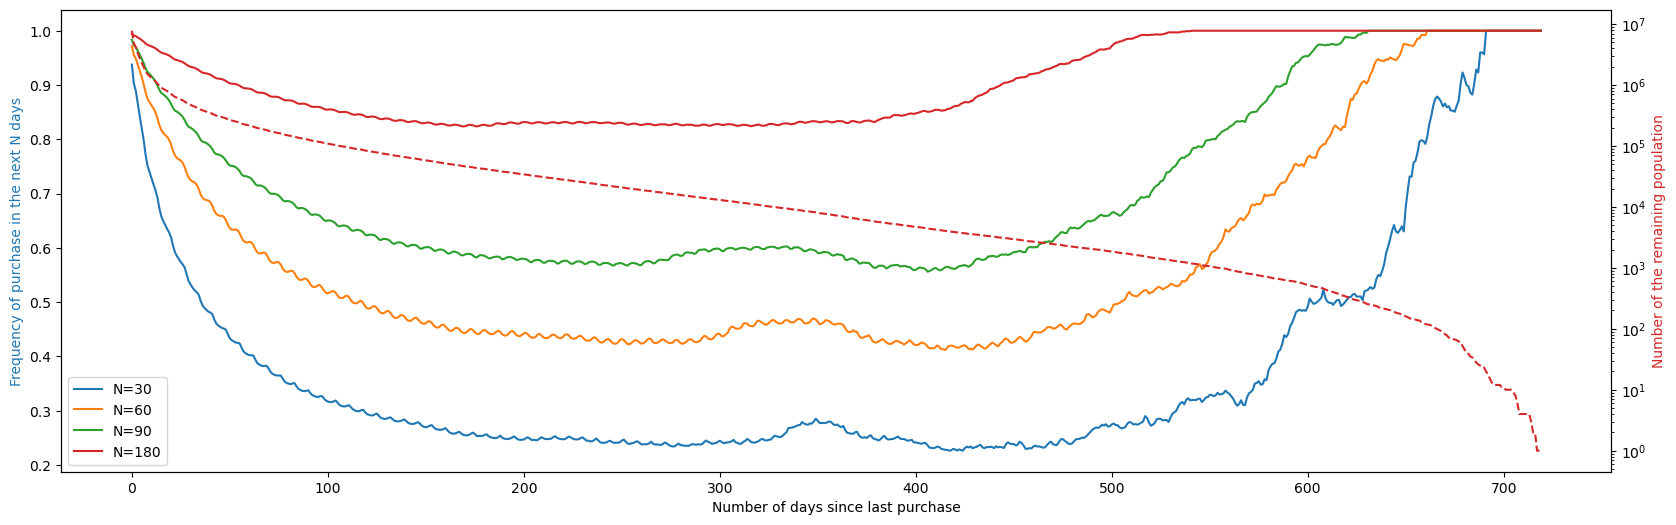

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_frequence(days_array, J=30):
    freq_list = []
    pop_list = []
    for i in range(int(max(days_array))):
        freq_list.append(np.mean((days_array[days_array > i] - i) < J))
        pop_list.append(np.sum((days_array > i)))
    return np.array(freq_list), np.array(pop_list)

fig, ax1 = plt.subplots(figsize=(20, 6))

N_list = [30, 60, 90, 180]
for N in N_list:
    freq_list, pop_list = get_frequence(flat, J=N)
    ax1.plot(freq_list, label=f'N={N}')

ax1.set_xlabel('Number of days since last purchase')
ax1.set_ylabel('Frequency of purchase in the next N days', color='tab:blue')
ax1.legend(loc='lower left')

ax2 = ax1.twinx()  # instantiate a second y-axis that shares the same x-axis
ax2.plot(pop_list, color='tab:red', linestyle='dashed')
ax2.set_ylabel('Number of the remaining population', color='tab:red')
ax2.set_yscale('log')  # Set y-axis to logarithmic scale

plt.show()


# Test feature function

In [1]:
from preprocessing import *

In [2]:
df_transaction = pd.read_csv('transactions_dataset.csv', sep=';')

In [3]:
df = def_temp_window(df_transaction, n_days=120)

In [5]:
df.is_churn.value_counts(normalize=True)

is_churn
False    0.629893
True     0.370107
Name: proportion, dtype: float64

## Test logistic regression

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame with features and 'is_churn' as the target variable
# Replace 'features' with the actual features you want to use for prediction
features = list(df.columns)[:-1]

# Replace 'is_churn' with the actual target variable
target = df['is_churn']

# Standardize the features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df[features].fillna(0), target, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


y_train_estim = model.predict(X_train)

# Evaluate the model on the train
accuracy_train = accuracy_score(y_train, y_train_estim)
conf_matrix_train = confusion_matrix(y_train, y_train_estim)
classification_rep_train = classification_report(y_train, y_train_estim)

print(f"Accuracy (train): {accuracy_train}")
print(f"Confusion Matrix (train):\n{conf_matrix_train}")
print(f"Classification Report (train):\n{classification_rep_train}")

# Evaluate the model on the test
accuracy_test = accuracy_score(y_test, y_pred)
conf_matrix_test = confusion_matrix(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

print(f"Accuracy (test): {accuracy_test}")
print(f"Confusion Matrix (test):\n{conf_matrix_test}")
print(f"Classification Report (test):\n{classification_rep_test}")

Accuracy (train): 0.8015273659500864
Confusion Matrix (train):
[[72101  9457]
 [16246 31700]]
Classification Report (train):
              precision    recall  f1-score   support

       False       0.82      0.88      0.85     81558
        True       0.77      0.66      0.71     47946

    accuracy                           0.80    129504
   macro avg       0.79      0.77      0.78    129504
weighted avg       0.80      0.80      0.80    129504

Accuracy (test): 0.8038361749444033
Confusion Matrix (test):
[[18059  2350]
 [ 4001  7966]]
Classification Report (test):
              precision    recall  f1-score   support

       False       0.82      0.88      0.85     20409
        True       0.77      0.67      0.71     11967

    accuracy                           0.80     32376
   macro avg       0.80      0.78      0.78     32376
weighted avg       0.80      0.80      0.80     32376



<AxesSubplot:>

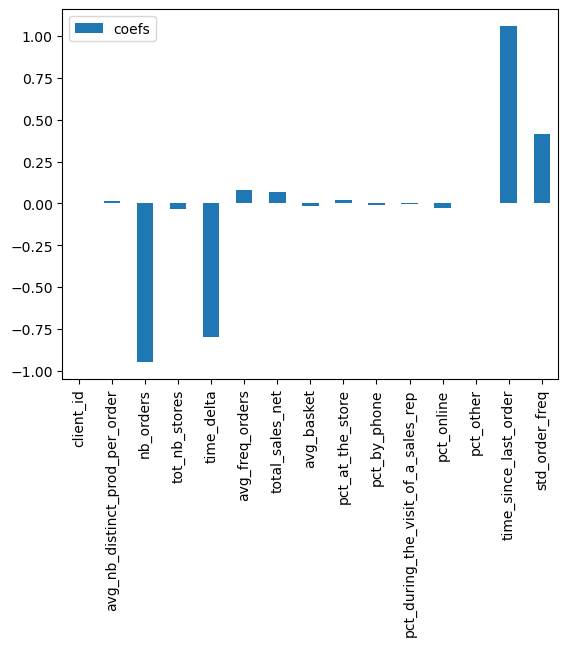

In [7]:
pd.DataFrame({'coefs' :model.coef_[0]}, features).plot.bar()

## Test XGB Classifier

In [14]:
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [57]:
# Split the dataset
# Replace 'features' with the actual features you want to use for prediction
features = list(df.columns)[:-1]

# Replace 'is_churn' with the actual target variable
target = df['is_churn']

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df[features].fillna(0)
                                                    , target
                                                    , test_size=0.2
                                                    , random_state=42)



# Objective function for hyperopt
def objective(params):
    model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        eval_metric='auc'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss = 1 - roc_auc_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

# Search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': hp.quniform('max_depth', 1, 8, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'random_state':42
}

# Run the optimizer
trials = Trials()
best_xgb = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

#print(f"Best hyperparameters:\n{best}")

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  1%|          | 1/100 [00:00<01:24,  1.18trial/s, best loss: 0.1952019101084993]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  2%|▏         | 2/100 [00:01<01:35,  1.03trial/s, best loss: 0.1952019101084993]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  3%|▎         | 3/100 [00:03<01:58,  1.22s/trial, best loss: 0.1952019101084993]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  4%|▍         | 4/100 [00:04<01:49,  1.14s/trial, best loss: 0.1952019101084993]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  5%|▌         | 5/100 [00:04<01:24,  1.12trial/s, best loss: 0.1952019101084993]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  6%|▌         | 6/100 [00:05<01:30,  1.04trial/s, best loss: 0.1903620963824263]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  7%|▋         | 7/100 [00:07<01:38,  1.06s/trial, best loss: 0.1903620963824263]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  8%|▊         | 8/100 [00:07<01:20,  1.14trial/s, best loss: 0.1903620963824263]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  9%|▉         | 9/100 [00:08<01:19,  1.14trial/s, best loss: 0.1903620963824263]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 10%|█         | 10/100 [00:09<01:22,  1.09trial/s, best loss: 0.19013723871765986]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 11%|█         | 11/100 [00:10<01:30,  1.01s/trial, best loss: 0.1888395289505841] 

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 12%|█▏        | 12/100 [00:11<01:27,  1.00trial/s, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 13%|█▎        | 13/100 [00:13<01:34,  1.09s/trial, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 14%|█▍        | 14/100 [00:14<01:40,  1.17s/trial, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 15%|█▌        | 15/100 [00:14<01:22,  1.03trial/s, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 16%|█▌        | 16/100 [00:16<01:30,  1.08s/trial, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 17%|█▋        | 17/100 [00:16<01:13,  1.12trial/s, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 18%|█▊        | 18/100 [00:17<01:13,  1.12trial/s, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 19%|█▉        | 19/100 [00:19<01:24,  1.04s/trial, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 20%|██        | 20/100 [00:20<01:33,  1.17s/trial, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 21%|██        | 21/100 [00:21<01:29,  1.14s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 22%|██▏       | 22/100 [00:22<01:20,  1.04s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 23%|██▎       | 23/100 [00:23<01:17,  1.00s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 24%|██▍       | 24/100 [00:24<01:31,  1.20s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 25%|██▌       | 25/100 [00:26<01:32,  1.23s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 26%|██▌       | 26/100 [00:26<01:16,  1.04s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 27%|██▋       | 27/100 [00:27<01:08,  1.07trial/s, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 28%|██▊       | 28/100 [00:29<01:19,  1.10s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 29%|██▉       | 29/100 [00:30<01:25,  1.20s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 30%|███       | 30/100 [00:30<01:09,  1.01trial/s, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 31%|███       | 31/100 [00:32<01:18,  1.14s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 32%|███▏      | 32/100 [00:33<01:15,  1.10s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 33%|███▎      | 33/100 [00:34<01:19,  1.19s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 34%|███▍      | 34/100 [00:35<01:17,  1.18s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 35%|███▌      | 35/100 [00:37<01:22,  1.27s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 36%|███▌      | 36/100 [00:39<01:41,  1.59s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 37%|███▋      | 37/100 [00:40<01:19,  1.25s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 38%|███▊      | 38/100 [00:41<01:11,  1.16s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 39%|███▉      | 39/100 [00:41<01:03,  1.04s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 40%|████      | 40/100 [00:44<01:29,  1.49s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 41%|████      | 41/100 [00:45<01:13,  1.25s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 42%|████▏     | 42/100 [00:45<00:59,  1.02s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 43%|████▎     | 43/100 [00:47<01:04,  1.13s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 44%|████▍     | 44/100 [00:47<00:59,  1.06s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 45%|████▌     | 45/100 [00:48<00:53,  1.04trial/s, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 46%|████▌     | 46/100 [00:49<00:54,  1.01s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 47%|████▋     | 47/100 [00:52<01:23,  1.58s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 48%|████▊     | 48/100 [00:53<01:08,  1.32s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 49%|████▉     | 49/100 [00:54<01:01,  1.20s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 50%|█████     | 50/100 [00:55<00:51,  1.03s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 51%|█████     | 51/100 [00:56<00:54,  1.12s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 52%|█████▏    | 52/100 [00:57<00:47,  1.01trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 53%|█████▎    | 53/100 [00:58<00:52,  1.12s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 54%|█████▍    | 54/100 [00:59<00:52,  1.13s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 55%|█████▌    | 55/100 [01:01<00:59,  1.32s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 56%|█████▌    | 56/100 [01:01<00:48,  1.11s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 57%|█████▋    | 57/100 [01:03<00:48,  1.13s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 58%|█████▊    | 58/100 [01:03<00:39,  1.06trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 59%|█████▉    | 59/100 [01:05<00:44,  1.09s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 60%|██████    | 60/100 [01:05<00:36,  1.10trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 61%|██████    | 61/100 [01:06<00:30,  1.29trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 62%|██████▏   | 62/100 [01:07<00:31,  1.21trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 63%|██████▎   | 63/100 [01:08<00:35,  1.05trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 64%|██████▍   | 64/100 [01:08<00:30,  1.18trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 65%|██████▌   | 65/100 [01:10<00:37,  1.08s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 66%|██████▌   | 66/100 [01:12<00:41,  1.22s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 67%|██████▋   | 67/100 [01:12<00:36,  1.12s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 68%|██████▊   | 68/100 [01:13<00:31,  1.02trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 69%|██████▉   | 69/100 [01:14<00:29,  1.07trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 70%|███████   | 70/100 [01:15<00:29,  1.03trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 71%|███████   | 71/100 [01:16<00:30,  1.06s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 72%|███████▏  | 72/100 [01:17<00:28,  1.02s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 73%|███████▎  | 73/100 [01:19<00:31,  1.15s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 74%|███████▍  | 74/100 [01:20<00:32,  1.23s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 75%|███████▌  | 75/100 [01:21<00:30,  1.22s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 76%|███████▌  | 76/100 [01:22<00:27,  1.15s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 77%|███████▋  | 77/100 [01:24<00:30,  1.34s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 78%|███████▊  | 78/100 [01:26<00:36,  1.64s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 79%|███████▉  | 79/100 [01:28<00:31,  1.51s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 80%|████████  | 80/100 [01:29<00:27,  1.38s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 81%|████████  | 81/100 [01:30<00:23,  1.26s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 82%|████████▏ | 82/100 [01:30<00:18,  1.03s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 83%|████████▎ | 83/100 [01:31<00:15,  1.12trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 84%|████████▍ | 84/100 [01:32<00:14,  1.08trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 85%|████████▌ | 85/100 [01:32<00:12,  1.23trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 86%|████████▌ | 86/100 [01:33<00:10,  1.34trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 87%|████████▋ | 87/100 [01:34<00:12,  1.08trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 88%|████████▊ | 88/100 [01:36<00:14,  1.22s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 89%|████████▉ | 89/100 [01:38<00:15,  1.45s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 90%|█████████ | 90/100 [01:39<00:11,  1.17s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 91%|█████████ | 91/100 [01:40<00:12,  1.38s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 92%|█████████▏| 92/100 [01:41<00:10,  1.26s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 93%|█████████▎| 93/100 [01:42<00:07,  1.09s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 94%|█████████▍| 94/100 [01:43<00:06,  1.05s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 95%|█████████▌| 95/100 [01:45<00:06,  1.38s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 96%|█████████▌| 96/100 [01:47<00:05,  1.38s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 97%|█████████▋| 97/100 [01:48<00:04,  1.34s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 98%|█████████▊| 98/100 [01:49<00:02,  1.29s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 99%|█████████▉| 99/100 [01:51<00:01,  1.43s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

100%|██████████| 100/100 [01:52<00:00,  1.12s/trial, best loss: 0.18760773124671903]


/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

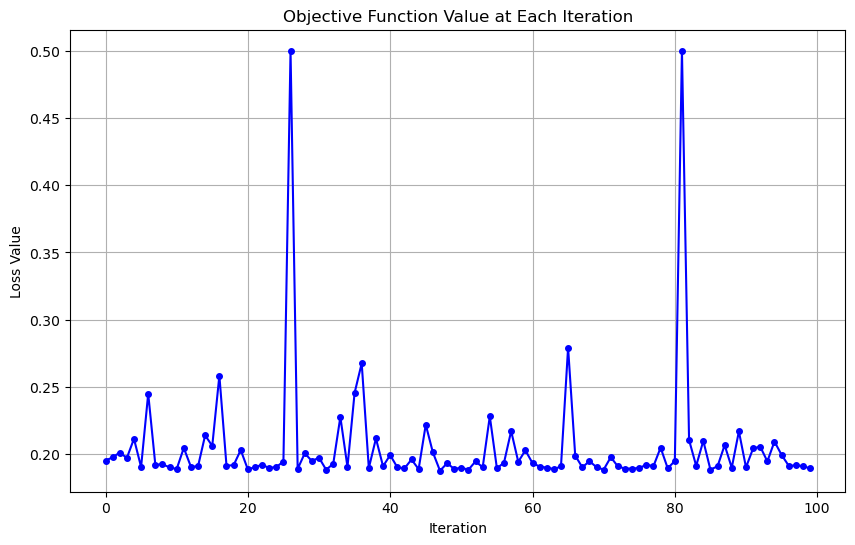

In [58]:
losses = [x['result']['loss'] for x in trials.trials]

plt.figure(figsize=(10, 6))
plt.plot(losses, '-o', color='blue', markersize=4)
plt.title('Objective Function Value at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

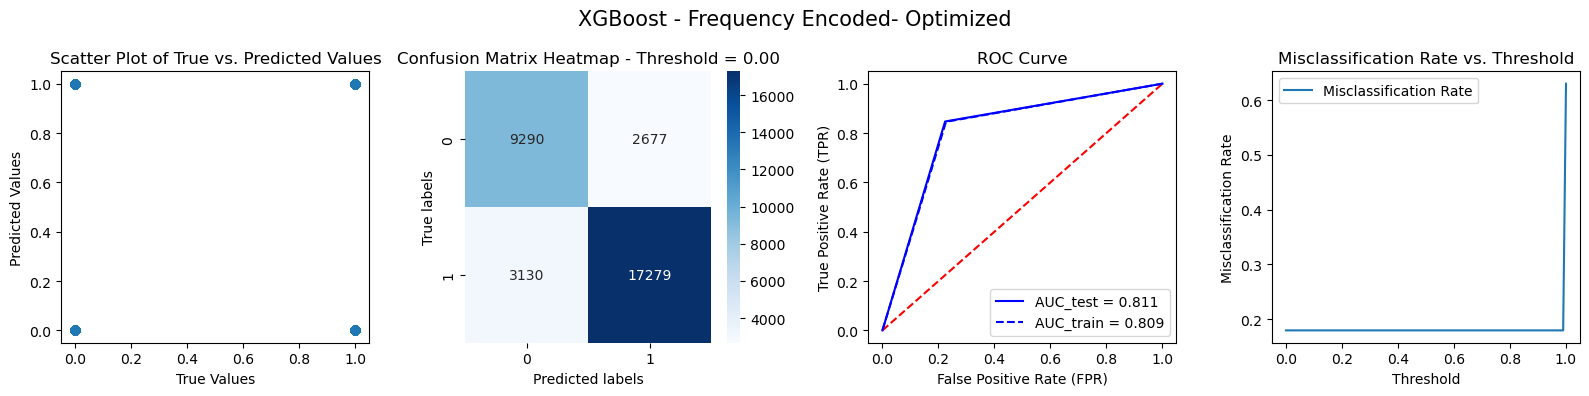

In [59]:
# Split the dataset
# Replace 'features' with the actual features you want to use for prediction
features = list(df.columns)[:-1]

# Replace 'is_churn' with the actual target variable
target = df['is_churn']

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df[features].fillna(0)
                                                    , target
                                                    , test_size=0.2
                                                    , random_state=42)


# 5. Perform regression using CatBoost

best_xgb['max_depth'] = int(best_xgb['max_depth'])

best_hyperparameters = best_xgb

regressor_xgb = xgb.XGBClassifier(**best_hyperparameters)
regressor_xgb.fit(X_train, y_train)

# Predict
y_pred = regressor_xgb.predict(X_test)

plot_func(y_test, y_pred, train=(y_train, regressor_xgb.predict(X_train)), name='XGBoost - Frequency Encoded- Optimized')

In [60]:
# Make predictions on the test set
y_pred = regressor_xgb.predict(X_test)

y_train_estim = regressor_xgb.predict(X_train)

# Evaluate the model on the train
accuracy_train = accuracy_score(y_train, y_train_estim)
conf_matrix_train = confusion_matrix(y_train, y_train_estim)
classification_rep_train = classification_report(y_train, y_train_estim)

print(f"Accuracy (train): {accuracy_train}")
print(f"Confusion Matrix (train):\n{conf_matrix_train}")
print(f"Classification Report (train):\n{classification_rep_train}")


# Evaluate the model on the test
accuracy_test = accuracy_score(y_test, y_pred)
conf_matrix_test = confusion_matrix(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

print(f"Accuracy (test): {accuracy_test}")
print(f"Confusion Matrix (test):\n{conf_matrix_test}")
print(f"Classification Report (test):\n{classification_rep_test}")

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

Accuracy (train): 0.8186310847541388
Confusion Matrix (train):
[[37062 10884]
 [12604 68954]]
Classification Report (train):
              precision    recall  f1-score   support

       False       0.75      0.77      0.76     47946
        True       0.86      0.85      0.85     81558

    accuracy                           0.82    129504
   macro avg       0.80      0.81      0.81    129504
weighted avg       0.82      0.82      0.82    129504

Accuracy (test): 0.820638744749197
Confusion Matrix (test):
[[ 9290  2677]
 [ 3130 17279]]
Classification Report (test):
              precision    recall  f1-score   support

       False       0.75      0.78      0.76     11967
        True       0.87      0.85      0.86     20409

    accuracy                           0.82     32376
   macro avg       0.81      0.81      0.81     32376
weighted avg       0.82      0.82      0.82     32376



## Test XGB Regressor

In [15]:
# Split the dataset
# Replace 'features' with the actual features you want to use for prediction
features = list(df.columns)[:-1]

# Replace 'is_churn' with the actual target variable
target = df['is_churn']

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df[features].fillna(0)
                                                    , target
                                                    , test_size=0.2
                                                    , random_state=42)



# Objective function for hyperopt
def objective(params):
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        eval_metric='auc'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss = 1 - roc_auc_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

# Search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': hp.quniform('max_depth', 1, 8, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'random_state':42
}

# Run the optimizer
trials = Trials()
best_xgb = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

#print(f"Best hyperparameters:\n{best}")

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  1%|          | 1/100 [00:01<03:16,  1.98s/trial, best loss: 0.1008852176795022]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  2%|▏         | 2/100 [00:03<02:25,  1.49s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  3%|▎         | 3/100 [00:03<01:36,  1.01trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  4%|▍         | 4/100 [00:05<02:07,  1.33s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  5%|▌         | 5/100 [00:06<01:59,  1.26s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  6%|▌         | 6/100 [00:07<01:50,  1.17s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  7%|▋         | 7/100 [00:08<01:28,  1.05trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  8%|▊         | 8/100 [00:09<01:34,  1.03s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  9%|▉         | 9/100 [00:09<01:17,  1.17trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 10%|█         | 10/100 [00:10<01:02,  1.44trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 11%|█         | 11/100 [00:11<01:10,  1.25trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 12%|█▏        | 12/100 [00:12<01:37,  1.11s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 13%|█▎        | 13/100 [00:13<01:16,  1.13trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 14%|█▍        | 14/100 [00:13<01:09,  1.24trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 15%|█▌        | 15/100 [00:14<01:09,  1.22trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 16%|█▌        | 16/100 [00:16<01:22,  1.01trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 17%|█▋        | 17/100 [00:16<01:15,  1.11trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 18%|█▊        | 18/100 [00:18<01:23,  1.01s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 19%|█▉        | 19/100 [00:19<01:31,  1.13s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 20%|██        | 20/100 [00:20<01:30,  1.14s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 21%|██        | 21/100 [00:21<01:30,  1.15s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 22%|██▏       | 22/100 [00:24<01:57,  1.51s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 23%|██▎       | 23/100 [00:26<02:12,  1.72s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 24%|██▍       | 24/100 [00:27<01:55,  1.52s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 25%|██▌       | 25/100 [00:27<01:29,  1.19s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 26%|██▌       | 26/100 [00:28<01:12,  1.02trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 27%|██▋       | 27/100 [00:30<01:41,  1.39s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 28%|██▊       | 28/100 [00:31<01:34,  1.31s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 29%|██▉       | 29/100 [00:33<01:38,  1.39s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 30%|███       | 30/100 [00:34<01:42,  1.46s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 31%|███       | 31/100 [00:36<01:43,  1.49s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 32%|███▏      | 32/100 [00:38<01:47,  1.58s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 33%|███▎      | 33/100 [00:39<01:28,  1.31s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 34%|███▍      | 34/100 [00:40<01:36,  1.46s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 35%|███▌      | 35/100 [00:41<01:22,  1.27s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 36%|███▌      | 36/100 [00:42<01:16,  1.20s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 37%|███▋      | 37/100 [00:44<01:21,  1.30s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 38%|███▊      | 38/100 [00:45<01:14,  1.20s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 39%|███▉      | 39/100 [00:46<01:12,  1.18s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 40%|████      | 40/100 [00:47<01:11,  1.19s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 41%|████      | 41/100 [00:48<00:57,  1.03trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 42%|████▏     | 42/100 [00:48<00:45,  1.27trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 43%|████▎     | 43/100 [00:49<00:44,  1.28trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 44%|████▍     | 44/100 [00:51<01:05,  1.17s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 45%|████▌     | 45/100 [00:52<01:10,  1.28s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 46%|████▌     | 46/100 [00:53<00:56,  1.04s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 47%|████▋     | 47/100 [00:54<00:58,  1.10s/trial, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 48%|████▊     | 48/100 [00:55<00:49,  1.05trial/s, best loss: 0.10042200712321137]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 49%|████▉     | 49/100 [00:56<00:57,  1.13s/trial, best loss: 0.10036134206639924]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 50%|█████     | 50/100 [00:57<00:59,  1.19s/trial, best loss: 0.10036134206639924]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 51%|█████     | 51/100 [00:59<01:00,  1.23s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 52%|█████▏    | 52/100 [01:00<00:56,  1.19s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 53%|█████▎    | 53/100 [01:01<00:51,  1.09s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 54%|█████▍    | 54/100 [01:03<01:03,  1.38s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 55%|█████▌    | 55/100 [01:04<01:03,  1.42s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 56%|█████▌    | 56/100 [01:05<00:50,  1.14s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 57%|█████▋    | 57/100 [01:05<00:40,  1.06trial/s, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 58%|█████▊    | 58/100 [01:06<00:43,  1.02s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 59%|█████▉    | 59/100 [01:07<00:33,  1.22trial/s, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 60%|██████    | 60/100 [01:07<00:26,  1.49trial/s, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 61%|██████    | 61/100 [01:09<00:36,  1.06trial/s, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 62%|██████▏   | 62/100 [01:11<00:53,  1.40s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 63%|██████▎   | 63/100 [01:13<00:54,  1.47s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 64%|██████▍   | 64/100 [01:13<00:43,  1.20s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 65%|██████▌   | 65/100 [01:15<00:45,  1.31s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 66%|██████▌   | 66/100 [01:17<00:47,  1.39s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 67%|██████▋   | 67/100 [01:18<00:44,  1.36s/trial, best loss: 0.10036058869208997]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 68%|██████▊   | 68/100 [01:19<00:44,  1.39s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 69%|██████▉   | 69/100 [01:21<00:44,  1.45s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 70%|███████   | 70/100 [01:22<00:41,  1.39s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 71%|███████   | 71/100 [01:24<00:43,  1.51s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 72%|███████▏  | 72/100 [01:25<00:41,  1.47s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 73%|███████▎  | 73/100 [01:26<00:37,  1.38s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 74%|███████▍  | 74/100 [01:29<00:45,  1.74s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 75%|███████▌  | 75/100 [01:31<00:43,  1.75s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 76%|███████▌  | 76/100 [01:32<00:34,  1.44s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 77%|███████▋  | 77/100 [01:33<00:31,  1.39s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 78%|███████▊  | 78/100 [01:34<00:28,  1.31s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 79%|███████▉  | 79/100 [01:36<00:34,  1.62s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 80%|████████  | 80/100 [01:38<00:30,  1.55s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 81%|████████  | 81/100 [01:39<00:26,  1.39s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 82%|████████▏ | 82/100 [01:41<00:28,  1.59s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 83%|████████▎ | 83/100 [01:42<00:26,  1.54s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 84%|████████▍ | 84/100 [01:43<00:23,  1.46s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 85%|████████▌ | 85/100 [01:45<00:22,  1.50s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 86%|████████▌ | 86/100 [01:46<00:19,  1.40s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 87%|████████▋ | 87/100 [01:48<00:19,  1.53s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 88%|████████▊ | 88/100 [01:50<00:18,  1.52s/trial, best loss: 0.10031740887977647]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 89%|████████▉ | 89/100 [01:51<00:15,  1.44s/trial, best loss: 0.10030511331971781]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 90%|█████████ | 90/100 [01:52<00:13,  1.39s/trial, best loss: 0.10030511331971781]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 91%|█████████ | 91/100 [01:53<00:11,  1.31s/trial, best loss: 0.10030511331971781]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 92%|█████████▏| 92/100 [01:54<00:09,  1.22s/trial, best loss: 0.10030511331971781]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 93%|█████████▎| 93/100 [01:55<00:06,  1.03trial/s, best loss: 0.10030511331971781]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 94%|█████████▍| 94/100 [01:56<00:06,  1.07s/trial, best loss: 0.10030511331971781]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 95%|█████████▌| 95/100 [01:57<00:05,  1.12s/trial, best loss: 0.10030511331971781]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 96%|█████████▌| 96/100 [01:58<00:03,  1.10trial/s, best loss: 0.10030511331971781]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 97%|█████████▋| 97/100 [01:59<00:03,  1.07s/trial, best loss: 0.10030511331971781]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 98%|█████████▊| 98/100 [01:59<00:01,  1.12trial/s, best loss: 0.10030511331971781]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 99%|█████████▉| 99/100 [02:00<00:00,  1.16trial/s, best loss: 0.10030511331971781]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

100%|██████████| 100/100 [02:01<00:00,  1.21s/trial, best loss: 0.10030511331971781]


/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

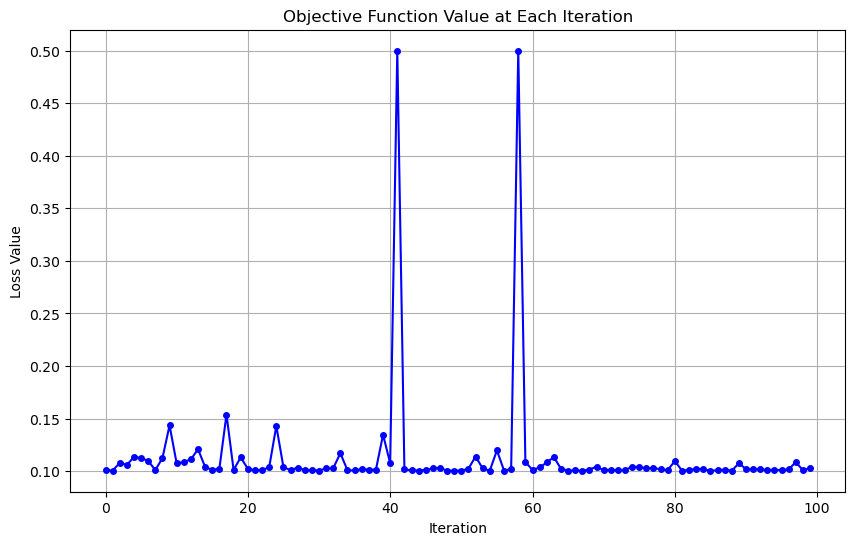

In [19]:
losses = [x['result']['loss'] for x in trials.trials]

plt.figure(figsize=(10, 6))
plt.plot(losses, '-o', color='blue', markersize=4)
plt.title('Objective Function Value at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

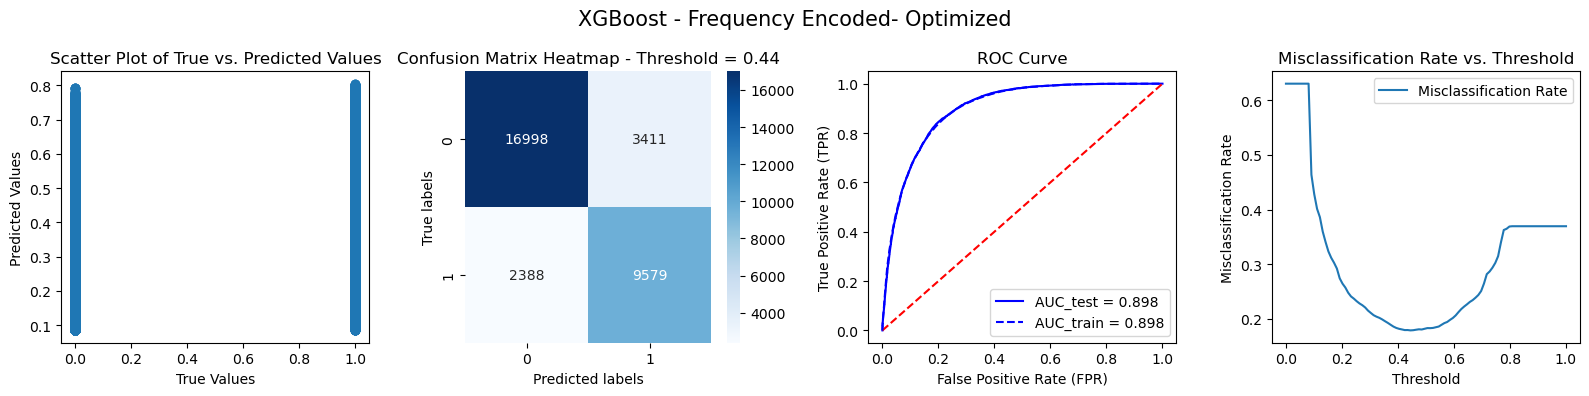

optimal_threshold :0.4444444444444445


In [20]:
# Split the dataset
# Replace 'features' with the actual features you want to use for prediction
features = list(df.columns)[:-1]

# Replace 'is_churn' with the actual target variable
target = df['is_churn']

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df[features].fillna(0)
                                                    , target
                                                    , test_size=0.2
                                                    , random_state=42)


# 5. Perform regression using CatBoost

best_xgb['max_depth'] = int(best_xgb['max_depth'])

best_hyperparameters = best_xgb

regressor_xgb = xgb.XGBRegressor(**best_hyperparameters)
regressor_xgb.fit(X_train, y_train)

# Predict
y_pred = regressor_xgb.predict(X_test)

plot_func(y_test, y_pred, train=(y_train, regressor_xgb.predict(X_train)), name='XGBoost - Frequency Encoded- Optimized')

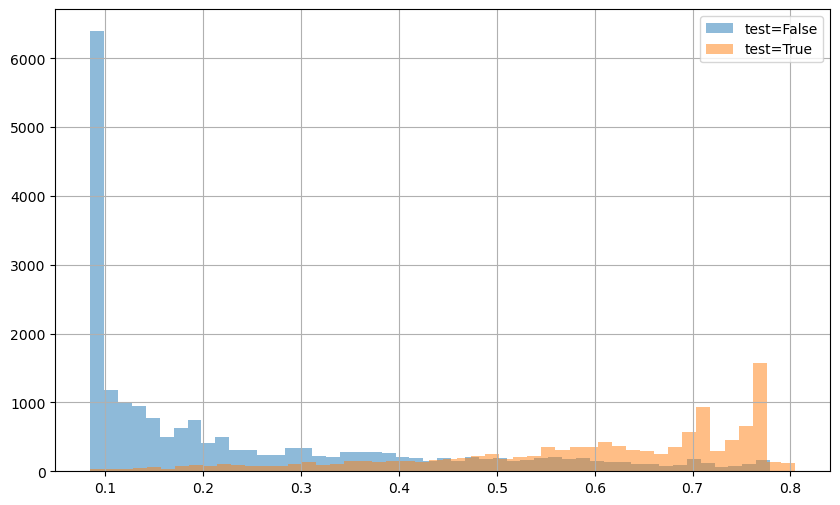

In [21]:
df_ = pd.DataFrame()
df_['pred'] = y_pred
df_['test'] = y_test.to_numpy()

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by 'test' and plot histograms
for key, group in df_.groupby(by='test'):
    group.pred.hist(ax=ax, bins=50, alpha=0.5, label=f"test={key}")

# Adding legend to differentiate between groups
ax.legend()

plt.show()

In [26]:
# Make predictions on the test set
y_pred = regressor_xgb.predict(X_test) > 0.4444444444444445

y_train_estim = regressor_xgb.predict(X_train) > 0.4444444444444445

# Evaluate the model on the train
accuracy_train = accuracy_score(y_train, y_train_estim)
conf_matrix_train = confusion_matrix(y_train, y_train_estim)
classification_rep_train = classification_report(y_train, y_train_estim)

print(f"Accuracy (train): {accuracy_train}")
print(f"Confusion Matrix (train):\n{conf_matrix_train}")
print(f"Classification Report (train):\n{classification_rep_train}")


# Evaluate the model on the test
accuracy_test = accuracy_score(y_test, y_pred)
conf_matrix_test = confusion_matrix(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

print(f"Accuracy (test): {accuracy_test}")
print(f"Confusion Matrix (test):\n{conf_matrix_test}")
print(f"Classification Report (test):\n{classification_rep_test}")

Accuracy (train): 0.818430318754633
Confusion Matrix (train):
[[67801 13757]
 [ 9757 38189]]
Classification Report (train):
              precision    recall  f1-score   support

       False       0.87      0.83      0.85     81558
        True       0.74      0.80      0.76     47946

    accuracy                           0.82    129504
   macro avg       0.80      0.81      0.81    129504
weighted avg       0.82      0.82      0.82    129504

Accuracy (test): 0.8208858413639734
Confusion Matrix (test):
[[16998  3411]
 [ 2388  9579]]
Classification Report (test):
              precision    recall  f1-score   support

       False       0.88      0.83      0.85     20409
        True       0.74      0.80      0.77     11967

    accuracy                           0.82     32376
   macro avg       0.81      0.82      0.81     32376
weighted avg       0.83      0.82      0.82     32376



/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

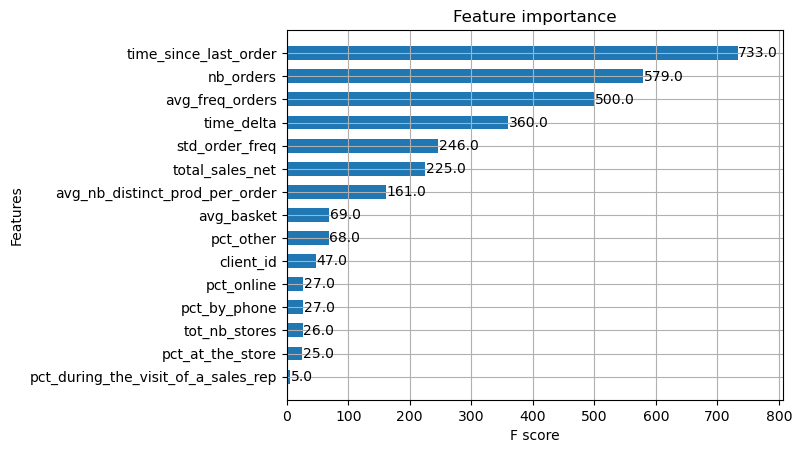

In [24]:
# Plot feature importance
xgb.plot_importance(regressor_xgb, importance_type='weight', height=0.6)
plt.show()


# Focus on one client

In [28]:
from preprocessing import *
df_transaction = pd.read_csv('transactions_dataset.csv', sep=';')
df = def_temp_window(df_transaction, n_days=120)

In [69]:
df.shape

(161880, 16)

In [33]:
df[df.is_churn].sort_values(by=['nb_orders','time_since_last_order'], ascending=[False,True])

,client_id,avg_nb_distinct_prod_per_order,nb_orders,tot_nb_stores,time_delta,avg_freq_orders,total_sales_net,avg_basket,pct_at_the_store,pct_by_phone,pct_during_the_visit_of_a_sales_rep,pct_online,pct_other,time_since_last_order,std_order_freq,is_churn
9988,140313,18.216578,374,10,570,0.656140,1.826948e+06,4884.886393,0.339572,0.588235,0.000000,0.072193,0.000000,37,159.0,True
147959,2078827,23.284900,351,8,504,0.696429,1.528642e+06,4355.106562,0.159544,0.452991,0.000000,0.387464,0.000000,103,146.0,True
100673,1416741,11.890490,347,5,528,0.657197,5.054197e+05,1456.540989,0.870317,0.129683,0.000000,0.000000,0.000000,79,153.0,True
29613,418279,5.419355,341,4,597,0.571189,3.385906e+05,992.934322,0.645161,0.269795,0.002933,0.079179,0.002933,9,171.0,True
145554,2045578,15.126100,341,4,563,0.605684,9.390937e+05,2753.940352,0.199413,0.800587,0.000000,0.000000,0.000000,44,161.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153127,2151541,1.000000,1,1,0,0.000000,7.896360e+01,78.963600,1.000000,0.000000,0.000000,0.000000,0.000000,607,NaN,True
154572,2171667,1.000000,1,1,0,0.000000,2.592770e+02,259.276976,0.000000,1.000000,0.000000,0.000000,0.000000,607,NaN,True
157057,2206477,1.000000,1,1,0,0.000000,1.242552e+02,124.255200,1.000000,0.000000,0.000000,0.000000,0.000000,607,NaN,True
158148,2222225,9.000000,1,1,0,0.000000,6.939223e+02,693.922287,1.000000,0.000000,0.000000,0.000000,0.000000,607,NaN,True


/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



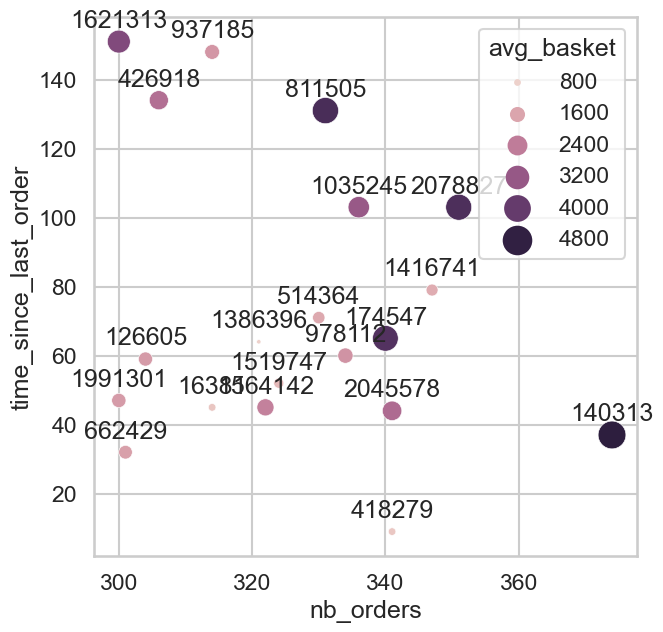

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame and 'client_id' is the feature you want to label
subset_df = df[df.is_churn].sort_values(by=['nb_orders', 'time_since_last_order'], ascending=[False, True]).head(20)

# Set the style and context using Seaborn
sns.set(style="whitegrid")
sns.set_context("talk")

# Create a scatter plot with Seaborn
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(x='nb_orders',
                     y='time_since_last_order',
                     size='avg_basket',
                     sizes=(10, 400),
                     hue='avg_basket',
                     data=subset_df)

# Add client_id as labels for each point
for index, row in subset_df.iterrows():
    ax.annotate(str(row['client_id']),
                xy=(row['nb_orders'], row['time_since_last_order']),
                xytext=(0, 15),  # Adjust the text position (x, y)
                textcoords='offset points',
                ha='center',
                va='center')

plt.show()


In [61]:
import plotly.express as px
import pandas as pd

# Assuming 'df_transaction' is your DataFrame
client_id = 140313

# Filter DataFrame for a specific client and date range
subset_df = df_transaction[(df_transaction['client_id'] == client_id) & (df_transaction['date_order'] <= '2019-09-22')]

# Group by date_order and sum the sales_net
grouped_df = subset_df.groupby(by='date_order').sales_net.sum().reset_index()

# Plot using Plotly
fig = px.bar(grouped_df, x='date_order', y='sales_net', labels={'sales_net': 'Total Sales'}, title=f'Total Sales for Client {client_id}')

# Update layout to set the x-axis range and center the title
fig.update_layout(
    xaxis=dict(
        range=[grouped_df['date_order'].min(), '2019-09-22'],
        # tickmode='array',
        # tickvals=grouped_df['date_order'].unique(),  # Use unique dates as tick values
        # ticktext=grouped_df['date_order'].dt.year.unique().astype(str),  # Use unique years as tick text
        # tickangle=45  # Rotate the tick labels for better visibility
    ),
    title=dict(
        x=0.5,  # Center title horizontally
        y=0.9   # Adjust the vertical position of the title
    )
)

# Show the plot
fig.show()


/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [72]:
df_transaction.sales_net.sum()

9367560275.589584

# Optim the anti_chrun campain

In [192]:
from preprocessing import *
from tqdm import tqdm
import pandas as pd

df_transaction = pd.read_csv('transactions_dataset.csv', sep=';')
df = def_temp_window(df_transaction, n_days=120)

  0%|          | 0/161880 [55:16<?, ?it/s]


In [193]:
df_relationship = pd.read_csv(r'CTM Handouts/sales_client_relationship_dataset.csv')

In [194]:
df_all = df.merge(df_relationship, on='client_id')

In [195]:
df_all['category'] = np.select(
    [
        (df_all['time_since_last_order'] <= 60) & (df_all.is_churn),
        (df_all['time_since_last_order'] > 60) & (df_all.total_sales_net > df_all.total_sales_net.quantile(.9)) & (df_all.is_churn),
        (df_all['time_since_last_order'] > 60) & (df_all.total_sales_net <= df_all.total_sales_net.quantile(.9)) & (df_all.is_churn)
    ],
    [
        'Activ_churn',
        'Unactive_top10',
        'Unactive_no_top10'
    ],
    default='Others'
)

df_all['cost'] = np.select(
    [
        (df_all['category'] == 'Activ_churn'),
        (df_all['category'] == 'Unactive_top10'),
        (df_all['category'] == 'Unactive_no_top10'),
    ],
    [
        .1,
        20,
        .1
    ],
    default=np.nan
)

In [196]:
df_all

,client_id,avg_nb_distinct_prod_per_order,nb_orders,tot_nb_stores,time_delta,avg_freq_orders,total_sales_net,avg_basket,pct_at_the_store,pct_by_phone,pct_during_the_visit_of_a_sales_rep,pct_online,pct_other,time_since_last_order,std_order_freq,is_churn,quali_relation,category,cost
0,6,2.700000,10,1,474,0.021097,3.492387e+03,349.238713,0.500000,0.500000,0.0,0.00000,0.0,101,181.0,False,Agreeable client,Others,NaN
1,7,7.500000,2,1,161,0.012422,1.190777e+03,595.388542,1.000000,0.000000,0.0,0.00000,0.0,152,113.0,True,Difficult client,Unactive_no_top10,0.1
2,14,22.407583,422,4,606,0.696370,2.603858e+06,6170.279778,0.085308,0.701422,0.0,0.21327,0.0,1,176.0,False,Agreeable client,Others,NaN
3,18,6.525210,238,1,605,0.393388,1.880877e+05,790.284559,0.659664,0.340336,0.0,0.00000,0.0,1,172.0,False,Agreeable client,Others,NaN
4,25,4.000000,1,1,0,0.000000,3.745861e+02,374.586096,1.000000,0.000000,0.0,0.00000,0.0,227,NaN,True,Difficult client,Unactive_no_top10,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161875,2274440,4.600000,20,3,599,0.033389,1.909148e+04,954.574212,0.700000,0.300000,0.0,0.00000,0.0,5,212.0,False,Difficult client,Others,NaN
161876,2274479,2.500000,2,1,485,0.004124,4.959214e+02,247.960700,1.000000,0.000000,0.0,0.00000,0.0,87,342.0,True,Agreeable client,Unactive_no_top10,0.1
161877,2274504,2.000000,2,1,425,0.004706,1.132566e+02,56.628300,0.500000,0.500000,0.0,0.00000,0.0,144,300.0,True,Demanding client,Unactive_no_top10,0.1
161878,2274508,4.000000,1,1,0,0.000000,7.270190e+01,72.701896,1.000000,0.000000,0.0,0.00000,0.0,584,NaN,True,Difficult client,Unactive_no_top10,0.1


In [197]:

# Groupby and resample operations outside the loop
grouped_sales = df_transaction.groupby(['client_id', 'date_order'])['sales_net'].sum().reset_index()
resampled_sales = grouped_sales.groupby(['client_id', pd.Grouper(key='date_order', freq='m')])['sales_net'].sum()
average_sales = resampled_sales.groupby('client_id').mean()



def get_coef_quali_relation(quali_relation):
    if quali_relation == 'Agreeable client': return .4 * .6 
    if quali_relation == 'Demanding client': return .3 * .5 
    if quali_relation == 'Difficult client': return .2 * .5 

# Use list comprehension with tqdm for the progress bar
#df_all['potential_gain'] = [
#    average_sales.loc[client_id] 
#    * get_coef_quali_relation(quali_relation)
#    for client_id, quali_relation in tqdm(zip(df_all['client_id'], df_all['quali_relation']), total=len(df_all))
#]*(~df_all.cost.isna())


df_all['potential_gain'] = [
    average_sales.loc[client_id] 
    * get_coef_quali_relation(quali_relation)
    for client_id, quali_relation in tqdm(zip(df_all['client_id'], df_all['quali_relation']), total=len(df_all))
]*(~df_all.cost.isna())

df_all['ROI'] = df_all['potential_gain'] / df_all['cost']

df_all.sort_values(by='ROI',ascending=False, inplace=True)

df_final = df_all[df_all.cost.cumsum() < 100_000 / 12]


100%|██████████| 161880/161880 [00:00<00:00, 234589.55it/s]


In [198]:
df_final

,client_id,avg_nb_distinct_prod_per_order,nb_orders,tot_nb_stores,time_delta,avg_freq_orders,total_sales_net,avg_basket,pct_at_the_store,pct_by_phone,...,pct_online,pct_other,time_since_last_order,std_order_freq,is_churn,quali_relation,category,cost,potential_gain,ROI
23851,335819,12.000000,1,1,0,0.000000,2.714222e+05,271422.153600,0.00,1.00,...,0.0,0.0,26,NaN,True,Demanding client,Activ_churn,0.1,40713.323040,407133.230400
11609,163536,2.400000,5,1,203,0.024631,1.339905e+06,267980.943097,0.20,0.80,...,0.0,0.0,57,87.0,True,Difficult client,Activ_churn,0.1,33190.908816,331909.088162
45324,640446,25.000000,1,1,0,0.000000,1.160598e+05,116059.821600,1.00,0.00,...,0.0,0.0,46,NaN,True,Agreeable client,Activ_churn,0.1,27854.357184,278543.571840
77344,1090388,1.000000,1,1,0,0.000000,1.416156e+05,141615.600000,0.00,1.00,...,0.0,0.0,24,NaN,True,Demanding client,Activ_churn,0.1,21242.340000,212423.400000
97205,1368084,19.000000,1,1,0,0.000000,8.619130e+04,86191.299400,0.00,1.00,...,0.0,0.0,418,NaN,True,Agreeable client,Unactive_no_top10,0.1,20685.911856,206859.118560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116412,1638304,1.333333,3,1,242,0.012397,2.625558e+02,87.518588,1.00,0.00,...,0.0,0.0,341,127.0,True,Agreeable client,Unactive_no_top10,0.1,21.004461,210.044611
146879,2063580,5.500000,8,3,337,0.023739,1.612316e+03,201.539560,0.75,0.25,...,0.0,0.0,267,120.0,True,Difficult client,Unactive_no_top10,0.1,21.000944,210.009440
31914,451118,2.333333,3,1,456,0.006579,4.199248e+02,139.974933,1.00,0.00,...,0.0,0.0,80,228.0,True,Demanding client,Unactive_no_top10,0.1,20.996240,209.962400
127056,1788643,4.000000,1,1,0,0.000000,8.748096e+01,87.480960,1.00,0.00,...,0.0,0.0,568,NaN,True,Agreeable client,Unactive_no_top10,0.1,20.995430,209.954304


In [201]:
df_final.cost.sum()

8326.000000000004

In [225]:
df_campain['count'] * df_campain.index.to_numpy()

cost
0.1     4766.0
20.0    3560.0
Name: count, dtype: float64

In [228]:
df_campain =  pd.DataFrame(df_final.cost.value_counts())
df_campain['cost'] = df_campain['count'] * df_campain.index.to_numpy() 
df_campain['cost'] = df_campain['cost'] / df_campain['cost'].sum()
df_campain

,count,cost
cost,,
0.1,47660,0.572424
20.0,178,0.427576


In [227]:
df_campain['cost'].sum()

8326.0

In [200]:
df_final.potential_gain.sum()

13676461.86513203